 ##   Geo based analysis:

    - Country based tweets count.
    - Top countries in terms of Tweets Volume.
    - List of top 15 countries in terms of tweet counts.
    

In [1]:
from __future__ import print_function

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn # For plotting
import time
import json

from IPython import display  # To work with graphs on jupyter
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc
from collections import namedtuple #function for creating tuple subclasses with named fields

import reverse_geocoder as rg # Country name from lat lon

In [2]:
# magic function to plot inline
%matplotlib inline

In [ ]:
if __name__ == "__main__":

    sc = SparkContext(appName="TwitterStreamer")
    ssc = StreamingContext(sc, 60 * 60)  # Setting 1hr interval
    sqlContext = SQLContext(sc)  # Sql context for running sql query
 
    # Host port of server which is sending text stream
    host = "localhost"
    port = 8400
    socketStream = ssc.socketTextStream(host, port) # Connecting to socket
    dStream = socketStream.window(60 * 60)  # Setting 1hr window
    
    def parseTweet(dStream): # Data Manupulation
#         try:
        data = json.loads(dStream)  # Load the json data
        coordinates = (data.get("lat", 0), data.get("lon", 0)),
        results = rg.search(coordinates)
        location = results[0]["cc"] 
        print(location)
        return [( # Tuple of name and follower count
                 location,
                )]
#         except:
#             return []
    
    fields = ("city", "count")
    Tweet = namedtuple('Tweet', fields)
    # DStream where all the computation is done
    (dStream.flatMap(parseTweet)\
            .transform(lambda rdd: rdd.map(lambda x:(x[0], 1))\
                        .reduceByKey(lambda a, b: a + b))\
            .map(lambda rec: Tweet(rec[0], rec[1]))\
            .foreachRDD(lambda rdd: rdd.toDF().sort(desc("count"))\
                       .limit(15).registerTempTable("tweets_loc")))
    

    ssc.start()
#    ssc.awaitTermination()

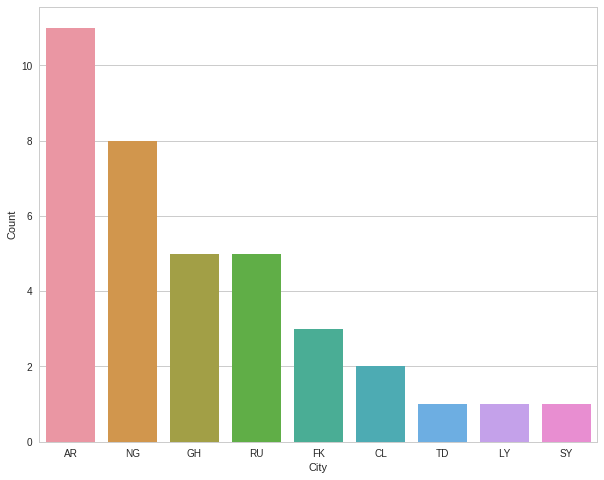

In [ ]:
while True:  # Display graph here
    try:
        time.sleep(60 * 60)  # Sleep 1hr, plot graph every hour
        topics = sqlContext.sql('Select city, count from tweets_loc')
        topics = topics.toPandas()
        topics.head()
        display.clear_output(wait=True)
        sn.set_style("whitegrid")  # Styling of plot
        sn.plt.figure(figsize = (10, 8)) # Figuresize of plot
        ax = sn.barplot(x=topics["city"], y=topics["count"], estimator=sum)
        ax.set(xlabel='City', ylabel='Count') # Labeling of plot
        sn.plt.show()
    except KeyboardInterrupt:  # User interrupt
        ssc.stop()
        print("Stoping the program")
        break
    # Continue even if there is exception and stop only on Keyboard Interrupt
    except Exception as e:  
        print(e)
        continue